In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sci
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


In [40]:
#import data
test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')
combine = [train,test]

In [21]:
#func for observing data from https://www.kaggle.com/nholloway/catboost-v-xgboost-v-lightgbm
def meet_ur_data(df):
    df = df
    description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
    numerical = []
    categorical = []
    for col in df.columns:
        obs = df[col].size
        p_nan = round(df[col].isna().sum()/obs, 2)
        num_nan = f'{p_nan}% ({df[col].isna().sum()}/{obs})'
        dtype = 'categorical' if df[col].dtype == object else 'numerical'
        numerical.append(col) if dtype == 'numerical' else categorical.append(col)
        rng = f'{len(df[col].unique())} labels' if dtype == 'categorical' else f'{df[col].min()}-{df[col].max()}'
        description[col] = [obs, num_nan, dtype, rng]

    pd.set_option('display.max_columns', 100)
    display(description)
    display(ibm_df.head())

In [22]:
meet_ur_data(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
observations(rows),891,891,891,891,891,891,891,891,891,891,891,891
percent missing,0.0% (0/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.2% (177/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.77% (687/891),0.0% (2/891)
dtype,numerical,numerical,numerical,categorical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,categorical
range,1-891,0-1,1-3,891 labels,2 labels,0.42-80.0,0-8,0-6,681 labels,0.0-512.3292,148 labels,4 labels


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Sex, and Embarked transform to numerical sex=(male = 1, female = 0), Embarked = (S=0, C=1, Q=2)

In [41]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 0,'male': 1}).astype(int)
freq_port = train.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0


In [42]:
meet_ur_data(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
observations(rows),891,891,891,891,891,891,891,891,891,891,891,891
percent missing,0.0% (0/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.2% (177/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.0% (0/891),0.77% (687/891),0.0% (0/891)
dtype,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,categorical,numerical,categorical,numerical
range,1-891,0-1,1-3,891 labels,0-1,0.42-80.0,0-8,0-6,681 labels,0.0-512.3292,148 labels,0-2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



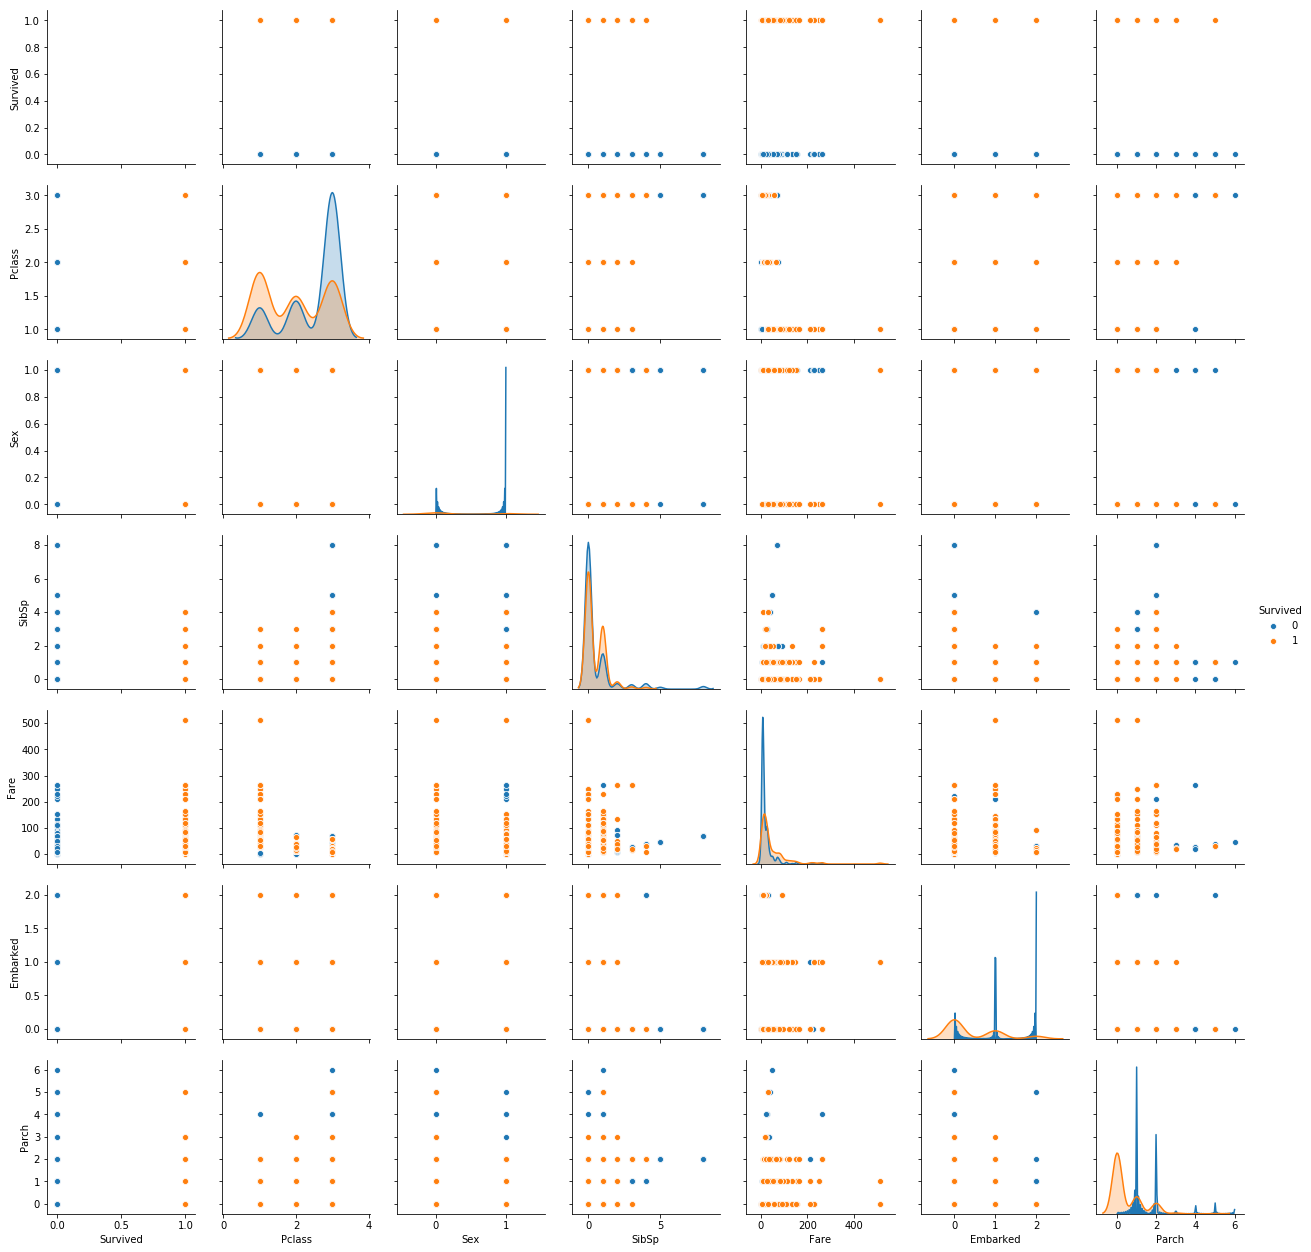

In [36]:
features = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked','Parch']
pairplot = sns.pairplot(train[features], diag_kind='kde', hue='Survived')
plt.show()

In [48]:
trace1 = go.Heatmap(
    z = np.absolute(train[features].astype(float).corr().values),
    x = train[features].columns.values,
    y = train[features].columns.values,
    colorscale = 'Portland', 
    reversescale = False, 
    opacity = 1.0)
        
data = [trace1]
layout = go.Layout(
    title = 'Correlation map (Numerical Features)',
    xaxis = dict(ticks = '', nticks = 36),
    yaxis = dict(ticks = ''),
    width = 700, height = 700
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)